# Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import time

# Data preprocessing (only need to be run once on the whole dataset)
# DON'T RUN IF YOU HAVE THE DATASETS ALREADY

This part is my codes to process the dataset as we discussed with TA.

The processed datasets are in the shared folder so you don't need to run this part again. It's time & GPU consuming.
- train_images.npz
- val_images.npz
- test_images.npz
- train_labels.csv
- val_labels.csv
- test_labels.csv

Final size of training set is 29883, validation is 6403, testing is 6407.

In [ ]:
data = np.load('drive/MyDrive/CSE547/project/data.npz')

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/CSE547/project/data.npz'

In [ ]:
#  List all arrays in the .npz file
print(len(data.files))

In [ ]:
print(f"arr_2: {data['arr_2']}")

In [ ]:
meta_data = pd.read_csv('drive/MyDrive/CSE547/project/data.csv', sep='\t')

In [ ]:
meta_data

In [ ]:
meta_data['class'].value_counts()

In [ ]:
# Step 1: Count the occurrences of each class
class_counts = meta_data['class'].value_counts()

# Step 2: Identify classes with counts >= 10,000
sufficient_class_counts = class_counts[class_counts >= 10000].index

# Step 3: Filter the DataFrame to keep only rows with sufficient class counts
filtered_meta_data = meta_data[meta_data['class'].isin(sufficient_class_counts)]

In [ ]:
filtered_meta_data['class'].value_counts()

In [ ]:
filtered_meta_data['case'].value_counts()

In [ ]:
# Down sampling
num_samples_per_case = 399

grouped = filtered_meta_data.groupby('case')

# Apply random sampling to each group
sampled_groups = grouped.apply(lambda x: x.sample(n=num_samples_per_case, random_state=0) if len(x) > num_samples_per_case else x)

# Remove the extra index level introduced by groupby apply
sampled_groups.index = sampled_groups.index.droplevel(0)

In [ ]:
sampled_groups

In [ ]:
from sklearn.model_selection import train_test_split

grouped = sampled_groups.groupby('class')

def split_group(group):
    train, temp = train_test_split(group, test_size=0.3, random_state=0)
    val, test = train_test_split(temp, test_size=0.5, random_state=0)
    return train, val, test

train_list = []
val_list = []
test_list = []

for name, group in grouped:
    train, val, test = split_group(group)
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

train_data = pd.concat(train_list)
val_data = pd.concat(val_list)
test_data = pd.concat(test_list)

# Print the shapes of the resulting sets to verify
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Testing set shape: {test_data.shape}")


In [ ]:
train_data.head(10)

In [ ]:
# Load the .npz file
image_data = np.load('drive/MyDrive/CSE547/project/data.npz')

# Function to retrieve images by indices
def get_images_by_indices(indices, image_data):
    images = []
    for index in indices:
        key = f'arr_{index}'
        if key in image_data:
            images.append(image_data[key])
    return np.array(images)

# Assuming 'train_data', 'val_data', and 'test_data' are your DataFrames with the original indices
train_indices = train_data.index
val_indices = val_data.index
test_indices = test_data.index

# Retrieve images for each set
train_images = get_images_by_indices(train_indices, image_data)
val_images = get_images_by_indices(val_indices, image_data)
test_images = get_images_by_indices(test_indices, image_data)

In [ ]:
# # Save the images into new .npz files to session memory
# np.savez('train_images.npz', *train_images)
# np.savez('val_images.npz', *val_images)
# np.savez('test_images.npz', *test_images)

In [ ]:
# Save the images into new .npz files
np.savez('drive/MyDrive/CSE547/project/train_images.npz', *train_images)
np.savez('drive/MyDrive/CSE547/project/val_images.npz', *val_images)
np.savez('drive/MyDrive/CSE547/project/test_images.npz', *test_images)

In [ ]:
# Select the 'class' and 'case' columns
train_labels = train_data[['class', 'case']]
val_labels = val_data[['class', 'case']]
test_labels = test_data[['class', 'case']]

In [ ]:
# # Save the labels into CSV files with the index to session memory
# train_labels.to_csv('train_labels.csv', index=True)
# val_labels.to_csv('val_labels.csv', index=True)
# test_labels.to_csv('test_labels.csv', index=True)

In [ ]:
# Save the labels into CSV files to my drive folder
train_labels.to_csv('drive/MyDrive/CSE547/project/train_labels.csv', index=True)
val_labels.to_csv('drive/MyDrive/CSE547/project/val_labels.csv', index=True)
test_labels.to_csv('drive/MyDrive/CSE547/project/test_labels.csv', index=True)

# Training Process

## Image data loading

In [3]:
train_images = np.load('drive/MyDrive/CSE547/project/train_images.npz')
val_images = np.load('drive/MyDrive/CSE547/project/val_images.npz')
test_images = np.load('drive/MyDrive/CSE547/project/test_images.npz')

In [ ]:
len(train_images.files)

29883

In [4]:
# If you want to convert all arrays to a list of NumPy arrays
train_images = [train_images[key] for key in train_images.files]
train_images = np.array(train_images)

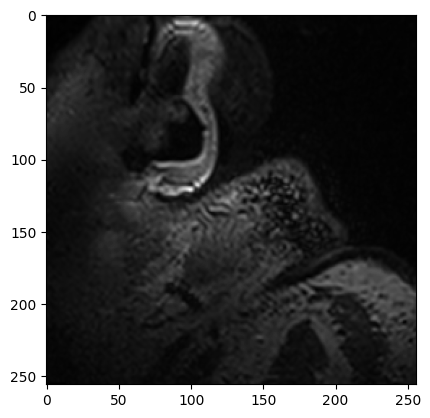

In [ ]:
# sample_normalized = pd.read_csv('drive/MyDrive/CSE547/project/data.npz', header=None)

plt.imshow(train_images[0].reshape((256,256)), cmap='gray')
plt.show()

In [ ]:
train_images.shape

(29883, 65536)

In [5]:
train_images=train_images.reshape(29883,256,256)

In [6]:
val_images = [val_images[key] for key in val_images.files]
val_images = np.array(val_images)
val_images=val_images.reshape(6403,256,256)

In [7]:
test_images = [test_images[key] for key in test_images.files]
test_images = np.array(test_images)
test_images=test_images.reshape(6407,256,256)

In [8]:
train_labels = pd.read_csv('drive/MyDrive/CSE547/project/train_labels.csv')
val_labels = pd.read_csv('drive/MyDrive/CSE547/project/val_labels.csv')
test_labels = pd.read_csv('drive/MyDrive/CSE547/project/test_labels.csv')

In [ ]:
train_labels

,Unnamed: 0,class,case
0,5780,Astrocytoma,9
1,41892,Astrocytoma,62
2,50748,Astrocytoma,74
3,66607,Astrocytoma,97
4,33034,Astrocytoma,48
...,...,...,...
29878,49517,abnormality,72
29879,28827,abnormality,42
29880,21035,abnormality,30
29881,24907,abnormality,36


In [ ]:
train_labels['class'].value_counts()

class
Astrocytoma          9216
Glioblastoma         8658
Oligodendroglioma    6703
abnormality          5306
Name: count, dtype: int64

In [9]:
import tensorflow as tf
#from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.inception_v3 import InceptionV3,preprocess_input
model = InceptionV3(include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    pooling=None)

# model.summary()

87910968/87910968 [==============================] - 5s 0us/step


In [10]:
import keras
from keras.models import Model
from keras.layers import Flatten,Dense, GlobalAveragePooling2D
inputs = keras.Input(shape=(299,299,3))
x = GlobalAveragePooling2D()(model.output)
#x=Flatten()(x)
outputs = Dense(4, activation='softmax')(x)

new_model = Model(inputs=model.input, outputs=outputs)
for layer in new_model.layers[:-10]:
    layer.trainable = False
# new_model.summary()

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
classes=train_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
train_labels= to_categorical(integer_labels)

classes=val_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
val_labels= to_categorical(integer_labels)

classes=test_labels['class']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(classes)
test_labels= to_categorical(integer_labels)

In [12]:
train_images=np.stack((train_images,) * 3, axis=-1)
val_images=np.stack((val_images,) * 3, axis=-1)
test_images=np.stack((test_images,) * 3, axis=-1)

In [13]:
train_images = preprocess_input(train_images)
val_images= preprocess_input(val_images)
test_images=preprocess_input(test_images)

In [14]:
print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)

(29883, 4)
(6403, 4)
(6407, 4)
(29883, 256, 256, 3)
(6403, 256, 256, 3)
(6407, 256, 256, 3)


## Model training

In [15]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("drive/MyDrive/CSE547/project/model_checkpoint1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

In [17]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

start_time = time.time()
history=new_model.fit(train_images, train_labels, epochs=30, batch_size=32, validation_data=(val_images, val_labels), callbacks=[reduce_lr, checkpoint])
end_time = time.time()

print("Training Time:", end_time - start_time)

Epoch 1/30
934/934 [==============================] - ETA: 0s - loss: 1.3784 - accuracy: 0.3241
Epoch 1: val_accuracy improved from -inf to 0.35468, saving model to drive/MyDrive/CSE547/project/model_checkpoint1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


934/934 [==============================] - 47s 42ms/step - loss: 1.3784 - accuracy: 0.3241 - val_loss: 1.3402 - val_accuracy: 0.3547 - lr: 1.0000e-04
Epoch 2/30
932/934 [============================>.] - ETA: 0s - loss: 1.3217 - accuracy: 0.3606
Epoch 2: val_accuracy improved from 0.35468 to 0.37311, saving model to drive/MyDrive/CSE547/project/model_checkpoint1.h5
934/934 [==============================] - 30s 32ms/step - loss: 1.3215 - accuracy: 0.3608 - val_loss: 1.3091 - val_accuracy: 0.3731 - lr: 1.0000e-04
Epoch 3/30
932/934 [============================>.] - ETA: 0s - loss: 1.2950 - accuracy: 0.3837
Epoch 3: val_accuracy improved from 0.37311 to 0.38904, saving model to drive/MyDrive/CSE547/project/model_checkpoint1.h5
934/934 [==============================] - 29s 31ms/step - loss: 1.2950 - accuracy: 0.3837 - val_loss: 1.2953 - val_accuracy: 0.3890 - lr: 1.0000e-04
Epoch 4/30
934/934 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.3979
Epoch 4: val_accur

In [18]:
training_accuracy = history.history['accuracy']
training_loss = history.history['loss']
print("Train Accuracy", training_accuracy[-2])
print("Train Loss", training_loss[-2])

Train Accuracy 0.4935247600078583
Train Loss 1.1482142210006714


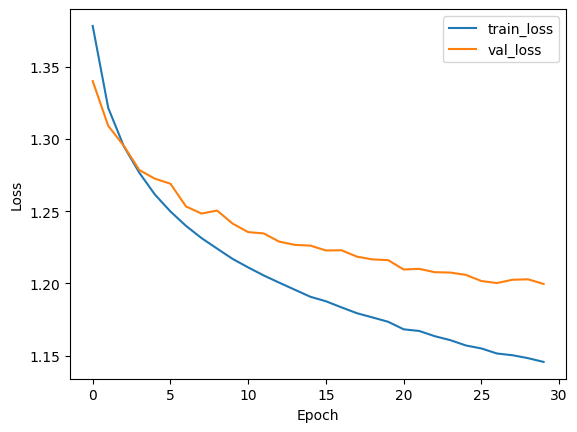

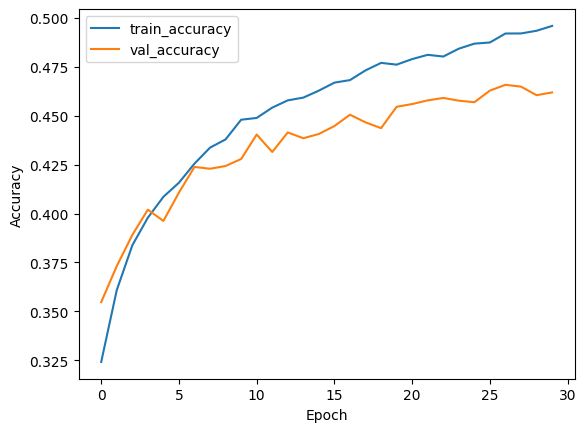

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [21]:
new_model.load_weights('drive/MyDrive/CSE547/project/model_checkpoint1.h5')

In [22]:
val_loss, val_accuracy = new_model.evaluate(val_images, val_labels)
print("Validation Accuracy", val_accuracy)
print("Validation Loss", val_loss)

201/201 [==============================] - 5s 23ms/step - loss: 1.2003 - accuracy: 0.4659
Validation Accuracy 0.4658753573894501
Validation Loss 1.2002530097961426


In [23]:
test_loss, test_accuracy = new_model.evaluate(test_images, test_labels)
print("Test Accuracy", test_accuracy)
print("Test Loss", test_loss)

201/201 [==============================] - 5s 27ms/step - loss: 1.1938 - accuracy: 0.4589
Test Accuracy 0.45887309312820435
Test Loss 1.1938132047653198


## Evaluation

In [24]:
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

201/201 [==============================] - 6s 21ms/step


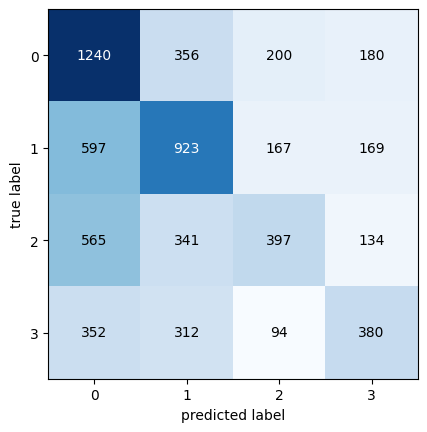

In [25]:
predictions = new_model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)

fig, ax = plot_confusion_matrix(conf_mat=cm)

In [26]:
from sklearn.metrics import precision_score, recall_score, fbeta_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f2_score = fbeta_score(true_labels, predicted_labels, beta=2, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F2 Score:", f2_score)

Precision: 0.45924591551461014
Recall: 0.45887310753862964
F2 Score: 0.4520182062150571


In [27]:
class_labels = label_encoder.classes_

print("Class Labels:")
for i, label in enumerate(class_labels):
    print(f"Class {i}: {label}")

Class Labels:
Class 0: Astrocytoma
Class 1: Glioblastoma
Class 2: Oligodendroglioma
Class 3: abnormality


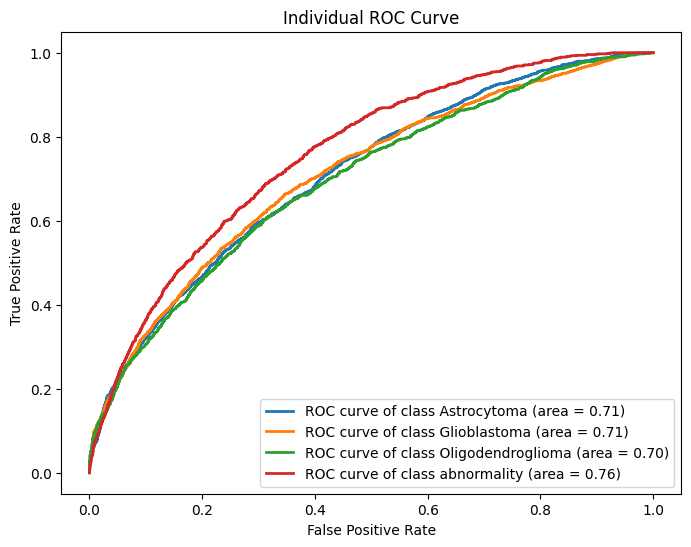

In [28]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class %s (area = %0.2f)' % (class_labels[i], roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Individual ROC Curve')
plt.legend(loc='lower right')
plt.show()


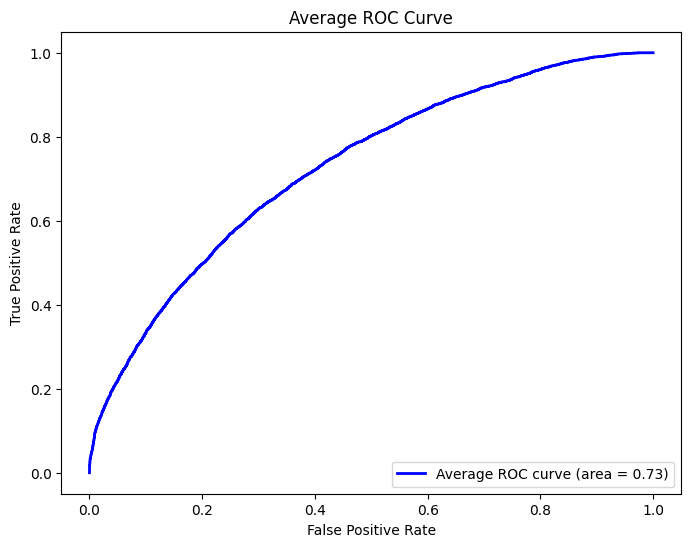

In [29]:
fpr_avg, tpr_avg, _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc_avg = auc(fpr_avg, tpr_avg)

plt.figure(figsize=(8, 6))
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label='Average ROC curve (area = %0.2f)' % roc_auc_avg)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc='lower right')
plt.show()
